# CF Recommendation System

**COMP9417**   

**Aim:** The aim of this project is to build a CF recommendation engine using the **Book-Crossing** dataset.

In [1]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from surprise import Reader, Dataset
from surprise import model_selection, accuracy
from surprise import NMF
from surprise import SVD
from surprise import SVDpp
from surprise import CoClustering
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
plt.style.use('seaborn-white') # Use seaborn-style plots
%matplotlib inline

#Read files.
users = pd.read_csv('./book_crossing_dataset/BX-Users.csv', sep=';', encoding='cp1252')
book_ratings = pd.read_csv('./book_crossing_dataset/BX-Book-Ratings.csv', sep=';',encoding='cp1252')
books = pd.read_csv('./book_crossing_dataset/BX-Books.csv', sep=';', usecols=range(5), encoding ='iso-8859-1')


#users
users.loc[(users.Age>100)|(users.Age<10), 'Age'] = np.nan#Reduce the age of the readers within a reasonable range. For example, older than 3 years old and younger than 90 years old.

# split_location = users.Location.str.split(',', 2, expand=True)
# split_location.columns = ['city', 'state', 'country']
# users = users.join(split_location)

# users.drop(columns=['Location'], inplace=True)#Split location to three parts: city, state, country.
# users.country.replace('', np.nan, inplace=True)#Replace empty string with nan.
# users.city.replace('', np.nan, inplace=True)#Replace empty string with nan.
# users.state.replace('', np.nan, inplace=True)#Replace empty string with nan.

#books
books.columns = books.columns.str.replace('Year-Of-Publication', 'Publicationyear')
books.Publicationyear = pd.to_numeric(books.Publicationyear, errors='coerce')
books.Publicationyear.replace(0, np.nan, inplace=True)
# books.drop(columns=['Image-URL-S', 'Image-URL-M', 'Image-URL-L'], inplace=True) # drop image-url columns

books = books.loc[~(books.ISBN.isin(books[books.Publicationyear<1900].ISBN))] # remove historical books
books = books.loc[~(books.ISBN.isin(books[books.Publicationyear>2020].ISBN))] # remove future books

# books.Publisher = books.Publisher.str.replace('&amp', '&', regex=False)#这步真的有必要吗？

#books_ratings
book_ratings.columns = book_ratings.columns.str.strip().str.replace('-', '_')
book_ratings = book_ratings[book_ratings.Book_Rating != 0]#Remove 0 rating rows.也感觉并不是特别必要。

books_with_ratings = book_ratings.join(books.set_index('ISBN'), on='ISBN')#join the books to books_ratings.
books_with_ratings.dropna(subset=['Book-Title'], inplace=True) # remove rows with missing title/author data
#作者把ISBN设为唯一是考虑到不同出版社出的书应该会同一个，他认为这个推荐系统的目的在于推荐书而不在于哪个出版社。但是我觉得不同出版社
#的出版，也会影响同一个本书内容的质量，比如有些出版社出的《简爱》就是会比另一些出版社的更加良心，排版插图也会更好
#所以我认为，不能把这个因素去除。就把ISBN唯一化这些操作去掉了。（之后如果觉得实在有必要，可以再加上这个操作，也不麻烦。）

users.columns = users.columns.str.replace('User-ID', 'User_ID')
books_users_ratings = books_with_ratings.join(users.set_index('User_ID'), on='User_ID')#join all tables by user_id.
books_users_ratings.columns = books_users_ratings.columns.str.strip().str.replace('-', '_')

#Create user_item_rating table, used in CF model.
user_item_rating = books_users_ratings[['User_ID', 'ISBN', 'Book_Rating']]




reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(user_item_rating, reader)

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
user_item_rating.count()

User_ID        383823
ISBN           383823
Book_Rating    383823
dtype: int64

## Investigate the 'users' dataframe

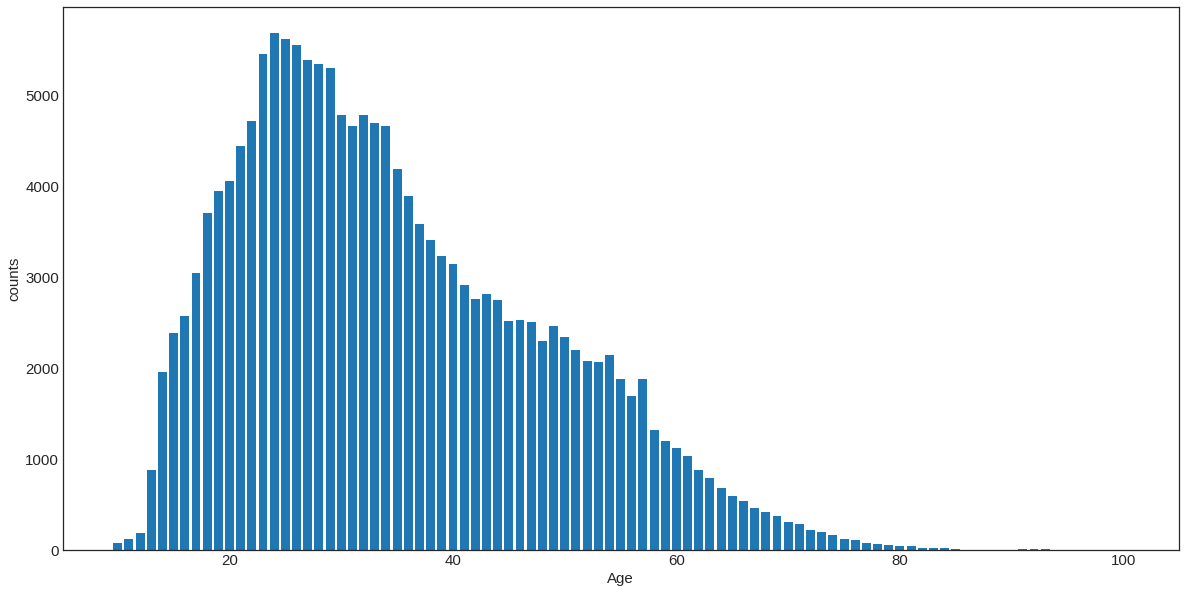

In [11]:
u = users.Age.value_counts().sort_index()
plt.figure(figsize=(20, 10))
plt.rcParams.update({'font.size': 15}) # Set larger plot font size
plt.bar(u.index, u.values)
plt.xlabel('Age')
plt.ylabel('counts')
plt.show()
# users.head()

## Investigate the 'books' dataframe

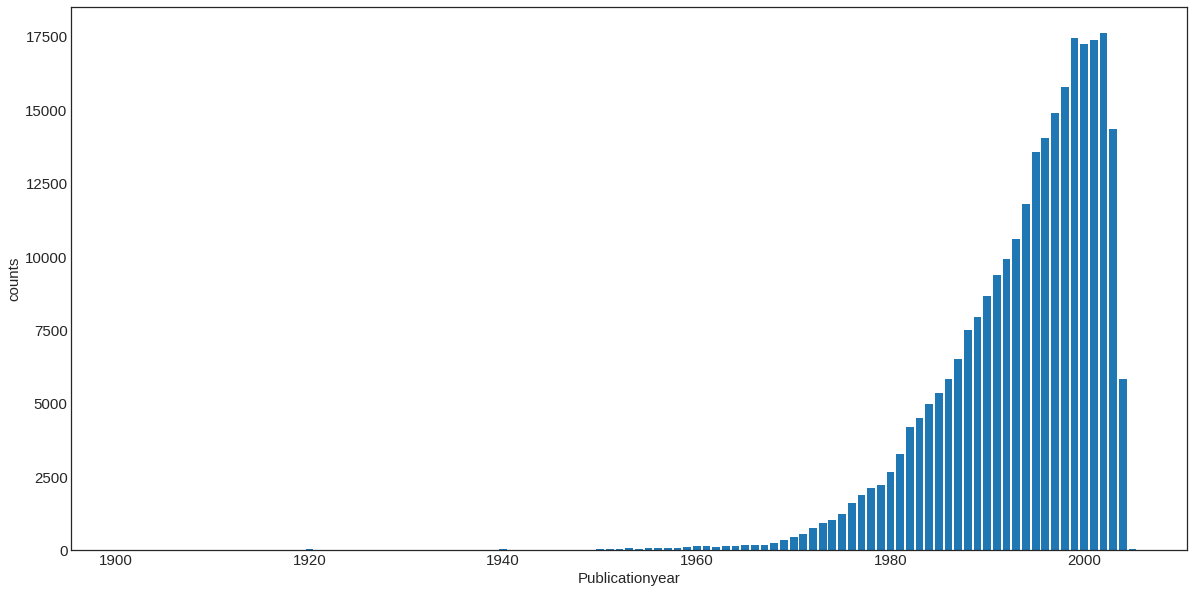

In [12]:
yr = books.Publicationyear.value_counts().sort_index()
yr = yr.where(yr>5) # filter out counts less than 5
plt.figure(figsize=(20, 10))
plt.rcParams.update({'font.size': 15}) # Set larger plot font size
plt.bar(yr.index, yr.values)
plt.xlabel('Publicationyear')
plt.ylabel('counts')
plt.show()

## Investigate 'book_ratings' table

Again, let's tidy up the column names.

Seems like most of the entries have a rating of zero!

After doing some research on the internet regarding this (and similar) datasets, it appears that the rating scale is actually from 1 to 10, and a 0 indicates an 'implicit' rather than an 'explicit' rating. An implicit rating represents an interaction (may be positive or negative) between the user and the item. Implicit interactions usually need to be handled differently from explicit ones.

For the modeling step we'll only be looking at *explicit* ratings, and so the 0 rating entry rows will be removed.

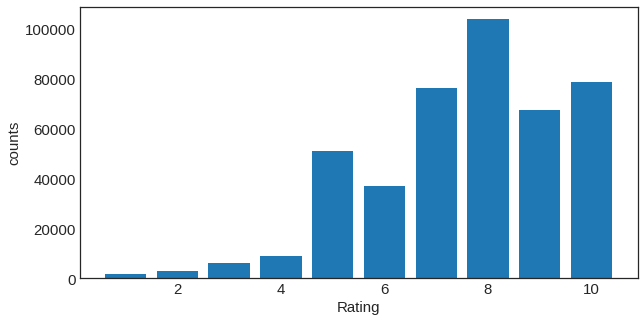

In [14]:
rtg = book_ratings.Book_Rating.value_counts().sort_index()

plt.figure(figsize=(10, 5))
plt.rcParams.update({'font.size': 15}) # Set larger plot font size
plt.bar(rtg.index, rtg.values)
plt.xlabel('Rating')
plt.ylabel('counts')
plt.show()

This is much more clear! Now we can see that 8 is the most frequent rating, while users tend to give ratings > 5, with very few low ratings given.

# Building a recommender system using collaborative filtering

Collaborative filtering use similarities of the 'user' and 'item' fields, with values of 'rating' predicted based on either user-item, or item-item similarity:
 - Item-Item CF: "Users who liked this item also liked..."
 - User-Item CF: "Users who are similar to you also liked..."
 
In both cases, we need to create a user-item matrix built from the entire dataset. We'll create a matrix for each of the training and testing sets, with the users as the rows, the books as the columns, and the rating as the matrix value. Note that this will be a very sparse matrix, as not every user will have watched every movie etc.

We'll first create a new dataframe that contains only the relevant columns (```user_id```, ```unique_isbn```, and ```book_rating```).

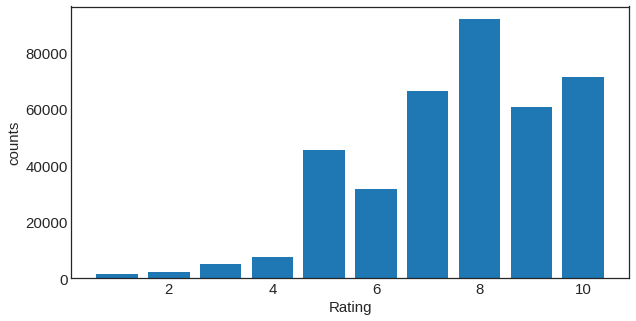

In [15]:
rtg = user_item_rating.Book_Rating.value_counts().sort_index()

plt.figure(figsize=(10, 5))
plt.rcParams.update({'font.size': 15}) # Set larger plot font size
plt.bar(rtg.index, rtg.values)
plt.xlabel('Rating')
plt.ylabel('counts')
plt.show()

Looks perfect! Continue.

# Using the ```surprise``` library for building a recommender system
Several common model-based algorithms including SVD, KNN, and non-negative matrix factorization are built-in!  
See [here](http://surprise.readthedocs.io/en/stable/getting_started.html#basic-usage) for the docs.

Where: SVD = Singular Value Decomposition (orthogonal factorization), NMF = Non-negative Matrix Factorization.

**Note** that when using the ```surprise``` library we don't need to manually create the mapping of user_id and unique_isbn to integers in a custom dict. See [here](http://surprise.readthedocs.io/en/stable/FAQ.html#raw-inner-note) for details. 

### SVD model

**_Using cross-validation (5 folds)_**

In [16]:
# Load SVD algorithm
model = SVD()

# Train on books dataset
%time model_selection.cross_validate(model, data, measures=['RMSE'], n_jobs=5,cv=10, verbose=True)

Evaluating RMSE of algorithm SVD on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    1.6339  1.6379  1.6303  1.6415  1.6458  1.6438  1.6180  1.6252  1.6277  1.6245  1.6328  0.0088  
Fit time          13.75   13.55   13.81   14.30   14.41   14.29   14.46   14.58   13.95   13.45   14.06   0.38    
Test time         0.21    0.28    0.25    0.21    0.23    0.23    0.23    0.22    0.20    0.21    0.23    0.02    
CPU times: user 1min 8s, sys: 646 ms, total: 1min 9s
Wall time: 1min 23s


{'test_rmse': array([1.63388799, 1.63787181, 1.63031239, 1.64149696, 1.64575934,
        1.64376358, 1.61795816, 1.62517517, 1.62765656, 1.62452028]),
 'fit_time': (13.751515626907349,
  13.548701286315918,
  13.812575101852417,
  14.300317764282227,
  14.40972113609314,
  14.294118881225586,
  14.461941480636597,
  14.580290079116821,
  13.948482990264893,
  13.448211669921875),
 'test_time': (0.21178793907165527,
  0.28252387046813965,
  0.24771690368652344,
  0.20847368240356445,
  0.2348344326019287,
  0.2324206829071045,
  0.22601079940795898,
  0.21575140953063965,
  0.2001020908355713,
  0.20635199546813965)}

The SVD model gives an average RMSE of ca. 1.64 after 5-folds, with a fit time of ca. 28 s for each fold.

### NMF model

In [166]:
# Load NMF algorithm
model = NMF()
# Train on books dataset
%time model_selection.cross_validate(model, data, measures=['RMSE'], cv=10, verbose=True)

Evaluating RMSE of algorithm NMF on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    2.4990  2.4815  2.4597  2.4701  2.4634  2.4633  2.4811  2.4650  2.4650  2.4753  2.4723  0.0115  
Fit time          39.69   45.88   48.24   44.02   43.59   42.57   43.02   42.18   44.62   48.50   44.23   2.58    
Test time         0.28    0.31    0.30    0.30    0.29    0.27    0.29    0.29    0.37    0.31    0.30    0.03    
CPU times: user 7min 35s, sys: 3.97 s, total: 7min 39s
Wall time: 7min 44s


{'test_rmse': array([2.49903772, 2.48153306, 2.45972642, 2.47006799, 2.46335234,
        2.46333562, 2.48109868, 2.46501613, 2.46499439, 2.47530794]),
 'fit_time': (39.68878102302551,
  45.87646198272705,
  48.23786282539368,
  44.01504421234131,
  43.59172606468201,
  42.56552600860596,
  43.024904012680054,
  42.18158173561096,
  44.62297987937927,
  48.50446915626526),
 'test_time': (0.27743101119995117,
  0.3066141605377197,
  0.29669189453125,
  0.30005407333374023,
  0.28624987602233887,
  0.27041196823120117,
  0.287106990814209,
  0.2915160655975342,
  0.36918187141418457,
  0.310427188873291)}

In [3]:
SVDppmodel = SVDpp()

%time model_selection.cross_validate(SVDppmodel, data, measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.6577  1.6476  1.6470  1.6459  1.6439  1.6484  0.0048  
Fit time          1150.80 1175.12 1150.90 1163.04 1179.14 1163.80 11.83   
Test time         15.74   15.26   14.79   15.89   15.23   15.38   0.39    
CPU times: user 1h 37min 51s, sys: 13 s, total: 1h 38min 4s
Wall time: 1h 38min 24s


{'test_rmse': array([1.6577234 , 1.64759927, 1.64699565, 1.64592592, 1.64393435]),
 'fit_time': (1150.8043429851532,
  1175.1193573474884,
  1150.904592037201,
  1163.0380742549896,
  1179.1386499404907),
 'test_time': (15.741928100585938,
  15.261472940444946,
  14.787420988082886,
  15.885241985321045,
  15.225876808166504)}

In [3]:
CoClusteringmodel = CoClustering()

%time model_selection.cross_validate(CoClusteringmodel, data, measures=['RMSE'], cv=10, verbose=True)

Evaluating RMSE of algorithm CoClustering on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    1.8688  1.8527  1.8528  1.8456  1.8349  1.8555  1.8288  1.8528  1.8407  1.8604  1.8493  0.0114  
Fit time          27.44   26.46   27.38   29.25   28.28   29.33   27.76   27.80   31.84   28.41   28.40   1.41    
Test time         0.30    0.51    0.32    0.29    0.31    0.29    0.30    0.28    0.30    0.30    0.32    0.06    
CPU times: user 4min 58s, sys: 2.27 s, total: 5min
Wall time: 5min 5s


{'test_rmse': array([1.86877187, 1.85269757, 1.8527994 , 1.84562557, 1.83491895,
        1.85548012, 1.82883519, 1.85275956, 1.84067192, 1.86039078]),
 'fit_time': (27.441571950912476,
  26.462570905685425,
  27.38216996192932,
  29.25297713279724,
  28.275870084762573,
  29.331010103225708,
  27.760194063186646,
  27.803400993347168,
  31.844605922698975,
  28.411500930786133),
 'test_time': (0.3049488067626953,
  0.5077171325683594,
  0.31685495376586914,
  0.29229187965393066,
  0.31412506103515625,
  0.2852327823638916,
  0.2976999282836914,
  0.28429079055786133,
  0.29709696769714355,
  0.29652976989746094)}

In [2]:
KNNBasicmodel = KNNBasic()

%time model_selection.cross_validate(KNNBasicmodel, data, measures=['RMSE'], cv=10, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNBasic on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    1.9550  1.9269  1.9446  1.9494  1.9267  1.9393  1.9362  1.9366  1.9341  1.9384  1.

{'test_rmse': array([1.95503598, 1.92689883, 1.94458085, 1.94943428, 1.92673164,
        1.93925069, 1.93623603, 1.93659582, 1.93405493, 1.93840509]),
 'fit_time': (301.0791528224945,
  295.33977484703064,
  295.8667778968811,
  293.0790169239044,
  293.1191260814667,
  304.39737820625305,
  294.659343957901,
  306.4251730442047,
  297.38123202323914,
  295.9373607635498),
 'test_time': (4.941538095474243,
  4.425936222076416,
  4.949044942855835,
  4.251443147659302,
  4.7189109325408936,
  4.321928262710571,
  3.9479031562805176,
  4.9409191608428955,
  4.21153712272644,
  4.756757020950317)}

In [3]:
KNNWithMeansmodel = KNNWithMeans()

%time model_selection.cross_validate(KNNWithMeansmodel, data, measures=['RMSE'], cv=10, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNWithMeans on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    1.8416  1.8290  1.8384  1.8378  1.8268  1.8362  1.8245  1.8327  1.8333  1.8341

{'test_rmse': array([1.84157317, 1.8289707 , 1.83839133, 1.83775875, 1.8268469 ,
        1.83616956, 1.82446225, 1.83268145, 1.83334177, 1.83406153]),
 'fit_time': (333.20009207725525,
  349.3229100704193,
  347.1997780799866,
  333.2338807582855,
  321.6053488254547,
  326.5748689174652,
  343.92419695854187,
  321.73685026168823,
  309.9673421382904,
  311.6091048717499),
 'test_time': (3.248699903488159,
  3.8688149452209473,
  3.1183648109436035,
  4.309756278991699,
  3.682321071624756,
  3.93294095993042,
  4.494416952133179,
  4.840296030044556,
  4.339203834533691,
  5.114516973495483)}

In [32]:
KNNWithZScoremodel = KNNWithZScore()

%time model_selection.cross_validate(KNNWithZScoremodel, data, measures=['RMSE'], cv=10, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNWithZScore on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    1.8233  1.8266  1.8364  1.8280  1.8423  1.8288  1.8341  1.8249  1.8266  1.838

{'test_rmse': array([1.8232619 , 1.82660428, 1.83636353, 1.82795623, 1.84234723,
        1.82876475, 1.834083  , 1.82490774, 1.8266136 , 1.83880394]),
 'fit_time': (311.65360498428345,
  295.7537989616394,
  305.98166584968567,
  323.34564304351807,
  340.29925298690796,
  319.7356469631195,
  312.564777135849,
  312.15333795547485,
  315.2343189716339,
  313.3657417297363),
 'test_time': (3.0687429904937744,
  3.864387035369873,
  3.0507211685180664,
  3.0854198932647705,
  3.8077712059020996,
  3.0802340507507324,
  3.1220591068267822,
  4.230602979660034,
  3.059566020965576,
  4.766063928604126)}

## Optimizing the SVD algorithm with parameter tuning
Since it seems like the SVD algorithm is our best choice, let's see if we can improve the predictions even further by optimizing some of the algorithm hyperparameters.

One way of doing this is to use the handy ```GridSearchCV``` method from the ```surprise``` library. When passed a range of hyperparameter values, ```GridSearchCV``` will automatically search through the parameter-space to find the best-performing set of hyperparameters.

In [2]:
# We'll remake the training set, keeping 20% for testing
trainset, testset = model_selection.train_test_split(data, test_size=0.2)

The mean RSME using the optimized parameters was 1.6351 over 5 folds, with an average fit time of ca. 24s.

In [3]:
### Use the new parameters with the training set
model = SVD(n_factors=80, lr_all=0.005, reg_all=0.04)
model.fit(trainset) # re-fit on only the training data using the best hyperparameters
test_pred = model.test(testset)
print("SVD : Test Set")
accuracy.rmse(test_pred, verbose=True)

SVD : Test Set
RMSE: 1.6344


1.6343632440507303

Using the optimized hyperparameters we see a slight improvement in the resulting RMSE (1.629) compared with the unoptimized SVD algorithm (1.635)1

## Testing some of the outputs (ratings and recommendations)
Would like to do an intuitive check of some of the recommendations being made.

Let's just choose a random user/book pair (represented in the ```suprise``` library as ```uid``` and ```iid```, respectively).

**Note:** The ```model``` being used here is the optimized SVD algorithm that has been fit on the training set.

In [59]:
# get a prediction for specific users and items.
uid = 276744  # the user_id int
iid = '038550120X' # the unique_isbn string
# This pair has an actual rating of 7!

pred = model.predict(uid, iid, verbose=True)

user: 276744     item: 038550120X r_ui = None   est = 7.50   {'was_impossible': False}


Can access the attributes of the ```predict``` method to get a nicer output.

In [60]:
print(f'The estimated rating for the book with the "unique_isbn" code {pred.iid} from user #{pred.uid} is {pred.est:.2f}.\n')
user_item_rating.info()
actual_rtg = user_item_rating[(user_item_rating.User_ID==pred.uid) & (user_item_rating.ISBN==pred.iid)].Book_Rating.values[0]
print(f'The real rating given for this was {actual_rtg:.2f}.')

The estimated rating for the book with the "unique_isbn" code 038550120X from user #276744 is 7.50.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 383823 entries, 1 to 1149778
Data columns (total 3 columns):
User_ID        383823 non-null int64
ISBN           383823 non-null object
Book_Rating    383823 non-null int64
dtypes: int64(2), object(1)
memory usage: 11.7+ MB
The real rating given for this was 7.00.


In [61]:
# get a prediction for specific users and items.
uid = 95095  # the user_id int
iid = '0140079963' # the unique_isbn string
# This pair has an actual rating of 6.0!

pred = model.predict(uid, iid, verbose=True)

user: 95095      item: 0140079963 r_ui = None   est = 6.96   {'was_impossible': False}


In [62]:
print(f'The estimated rating for the book with the "unique_isbn" code {pred.iid} from user #{pred.uid} is {pred.est:.2f}.\n')
actual_rtg = user_item_rating[(user_item_rating.User_ID==pred.uid) & (user_item_rating.ISBN==pred.iid)].Book_Rating.values[0]
print(f'The real rating given for this was {actual_rtg:.2f}.')

The estimated rating for the book with the "unique_isbn" code 0140079963 from user #95095 is 6.96.

The real rating given for this was 6.00.


The following function was adapted from the ```surprise``` docs, and can be used to get the top book recommendations for each user.

In [27]:
from collections import defaultdict

def get_top_n_for_user(predictions, userid, n=10):

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
        
    reading_list = defaultdict(list)
    top_n = get_top_n(pred, n=10)
    for n in top_n[userid]:
        book, rating = n
        title = books_users_ratings.loc[books_users_ratings.ISBN==book].Book_Title.unique()[0]
        reading_list[title] = rating
#     for  in reading_list:
#         print(i,j)
#     print(reading_list)
    return reading_list

pred = model.test(testset)
i = get_top_n_for_user(pred, 60337, n=10)


In [31]:
i

defaultdict(list,
            {'The Secret Life of Bees': 9.511986047775366,
             'Lucky : A Memoir': 9.01475949851496,
             'Plays Well With Others (Vintage Contemporaries)': 8.806602970214348,
             'Shoes: A Celebration of Pumps, Sandals, Slippers &amp More': 8.781625098781419,
             'MS Guide Womans Healt': 8.610500804271977,
             'Classic Crews : A Harry Crews Reader': 8.606798402697429,
             'Grace For The Moment': 8.584277014466021,
             'Grief Observed': 8.547527767297066,
             'Outing Yourself: How to Come Out as Lesbian or Gay to Your Family, Friends, and Coworkers': 8.547527767297066,
             'Bloody Sunset in St. Augustine: A True Story': 8.547527767297066,
             1: [],
             0: []})

Let's get the Top 10 recommended books for each user_id in the test set.

Have tried out a few different ```userid``` entries (from the ```testset```) to see what the top 10 books that user would like are and they seem pretty well related, indicating that the recommendation engine is performing reasonably well!

# Summary

In this notebook a dataset from the 'Book-Crossing' website was used to create a recommendation system. A few different approaches were investigated, including memory-based correlations, and model-based matrix factorization algorithms[2]. Of these, the latter - and particularly the Singular Value Decomposition (SVD) algorithm - gave the best performance as assessed by comparing the predicted book ratings for a given user with the actual rating in a test set that the model was not trained on.

The only fields that were used for the model were the "user ID", "book ID", and "rating". There were others available in the dataset, such as "age", "location", "publisher", "year published", etc, however for these types of recommendation systems it has often been found that additional data fields do not increase the accuracy of the models significantly[1]. A "Grid Search Cross Validation" method was used to optimize some of the hyperparameters for the model, resulting in a slight improvement in model performance from the default values.

Finally, we were able to build a recommender that could predict the 10 most likely book titles to be rated highly by a given user.

It should be noted that this approach still suffers from the "cold start problem"[3] - that is, for users with no ratings or history the model will not make accurate predictions. One way we could tackle this problem may be to initially start with popularity-based recommendations, before building up enough user history to implement the model. Another piece of data that was not utilised in the current investigation was the "implicit" ratings - denoted as those with a rating of "0" in the dataset. Although more information about these implicit ratings (for example, does it represent a positive or negative interaction), these might be useful for supplementing the "explicit" ratings recommender.

# References

1. http://blog.ethanrosenthal.com/2015/11/02/intro-to-collaborative-filtering/
2. https://cambridgespark.com/content/tutorials/implementing-your-own-recommender-systems-in-Python/index.html
3. https://towardsdatascience.com/building-a-recommendation-system-for-fragrance-5b00de3829da